Nama : Rafil Moehamad Alif <br>
NIM : 211351116 <br>
Kelas : Malam B

# import Dataset

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rafilalif","key":"08750a78f72c95be09429af93bd38216"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [3]:
!kaggle datasets download -d bejopamungkas/transaksi-pembelian-penjualan-sembako

  0% 0.00/13.8k [00:00<?, ?B/s]
100% 13.8k/13.8k [00:00<00:00, 31.1MB/s]


In [4]:
!mkdir project_uas
!unzip transaksi-pembelian-penjualan-sembako.zip -d project_uas
!ls project_uas

Archive:  transaksi-pembelian-penjualan-sembako.zip
  inflating: project_uas/pemasukan barang.csv  
  inflating: project_uas/penjualan barang.csv  
'pemasukan barang.csv'	'penjualan barang.csv'


# import library yang digunakan

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import networkx as nx
import plotly.graph_objects as go
from mlxtend.frequent_patterns import association_rules, apriori
import warnings
warnings.filterwarnings('ignore')

# Data Discovery

In [6]:
df=pd.read_csv('/content/project_uas/penjualan barang.csv')

In [7]:
df.head()

,Unnamed: 0,tanggal,nama.pembeli,nama.barang,kuantum,nominal
0,1,2020-01-02,TOKO HERUNIAWATI,BERAS,1000.0,9840000.0
1,2,2020-01-02,TOKO HERUNIAWATI,DAGING,120.0,8400000.0
2,3,2020-01-02,TOKO APRILIA SUKRISNI,BERAS,6000.0,62910000.0
3,4,2020-01-02,TOKO APRILIA SUKRISNI,MIGOR,408.0,4855200.0
4,5,2020-01-02,TOKO APRILIA SUKRISNI,TEPUNG,140.0,1162000.0


In [8]:
df.shape

(1289, 6)

In [9]:
df['nama.barang'].value_counts()

BERAS     836
DAGING    184
GULA      121
TEPUNG     77
MIGOR      71
Name: nama.barang, dtype: int64

In [10]:
df['nama.pembeli'].value_counts()

TOKO BERKAH DUA PUTRA    36
Warung Nak Zihan         32
TOKO BU YULI             31
TOKO BUNGUR              28
TOKO SIDAK               28
                         ..
TOKO ODONG SOBARI         1
TOKO SITI CHOMSAH         1
TOKO DENY WIDODO          1
TOKO SAMSUL HIDAYAT       1
TOKO RITA ROSANTI         1
Name: nama.pembeli, Length: 171, dtype: int64

In [11]:
df.isnull().sum()

Unnamed: 0      0
tanggal         0
nama.pembeli    0
nama.barang     0
kuantum         0
nominal         0
dtype: int64

# EDA (minimal 5)

(-1.25, 1.25, -1.25, 1.25)

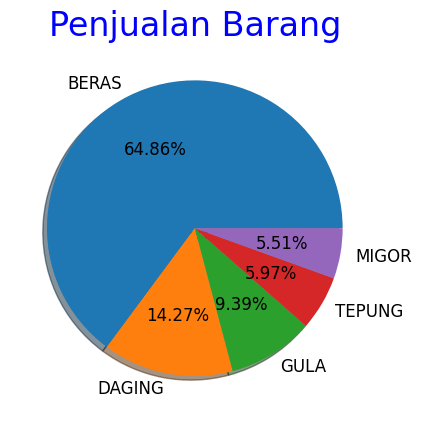

In [12]:
plt.rcParams.update({'font.size': 12})
ax=df['nama.barang'].value_counts().plot.pie(autopct='%1.2f%%',shadow=True)
ax.set_title(label = "Penjualan Barang", fontsize = 24,color='Blue')
plt.axis('off')

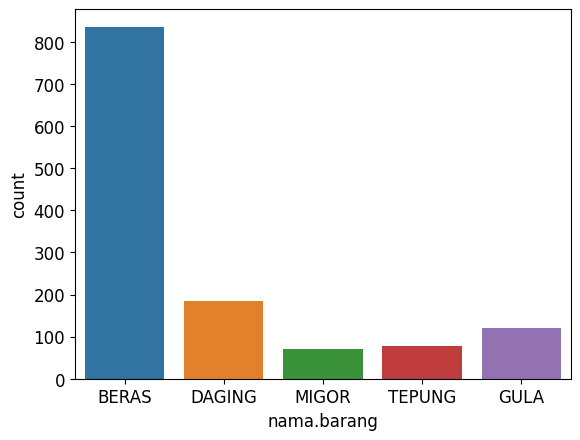

In [13]:
sns.countplot(x=df['nama.barang'], data=df)
plt.show()

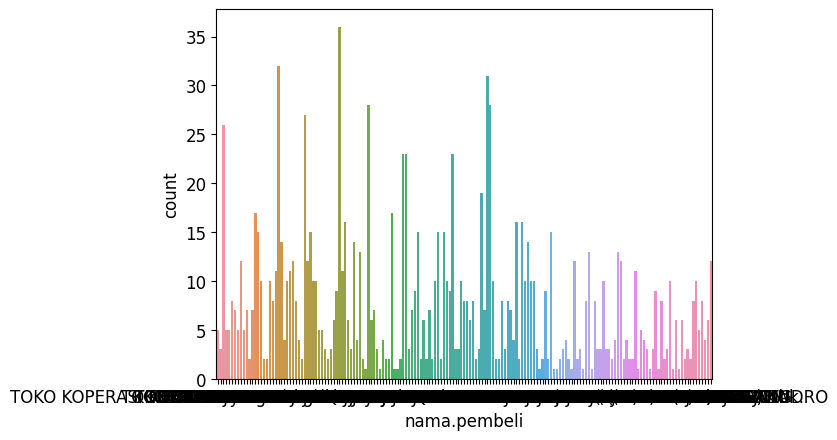

In [14]:
sns.countplot(x=df['nama.pembeli'], data=df)
plt.show()

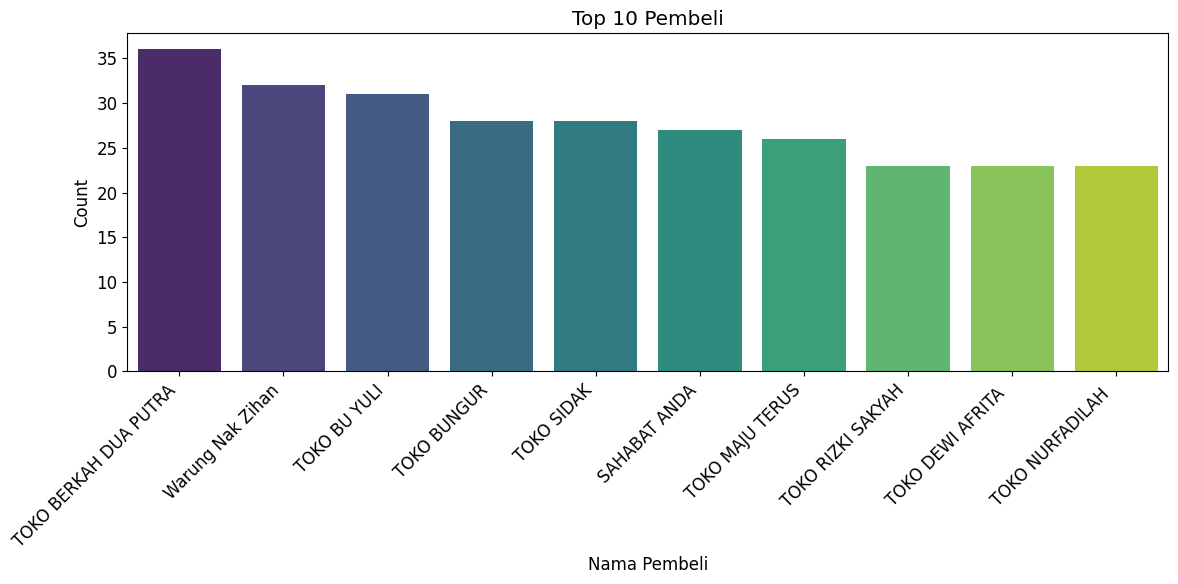

In [16]:
top_pembeli = df['nama.pembeli'].value_counts().nlargest(10)

plt.figure(figsize=(12, 6))
sns.countplot(x=df['nama.pembeli'], data=df, order=top_pembeli.index, palette='viridis')
plt.xlabel('Nama Pembeli')
plt.ylabel('Count')
plt.title('Top 10 Pembeli')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

# Preprocessing

In [18]:
df['tanggal'] = pd.to_datetime(df['tanggal'], format= "%Y-%m-%d")

In [19]:
df["tanggal"].dtype

dtype('<M8[ns]')

In [20]:
df["month"] = df['tanggal'].dt.month
df["day"] = df['tanggal'].dt.day
df["year"] = df['tanggal'].dt.year
df.head()

,Unnamed: 0,tanggal,nama.pembeli,nama.barang,kuantum,nominal,month,day,year
0,1,2020-01-02,TOKO HERUNIAWATI,BERAS,1000.0,9840000.0,1,2,2020
1,2,2020-01-02,TOKO HERUNIAWATI,DAGING,120.0,8400000.0,1,2,2020
2,3,2020-01-02,TOKO APRILIA SUKRISNI,BERAS,6000.0,62910000.0,1,2,2020
3,4,2020-01-02,TOKO APRILIA SUKRISNI,MIGOR,408.0,4855200.0,1,2,2020
4,5,2020-01-02,TOKO APRILIA SUKRISNI,TEPUNG,140.0,1162000.0,1,2,2020


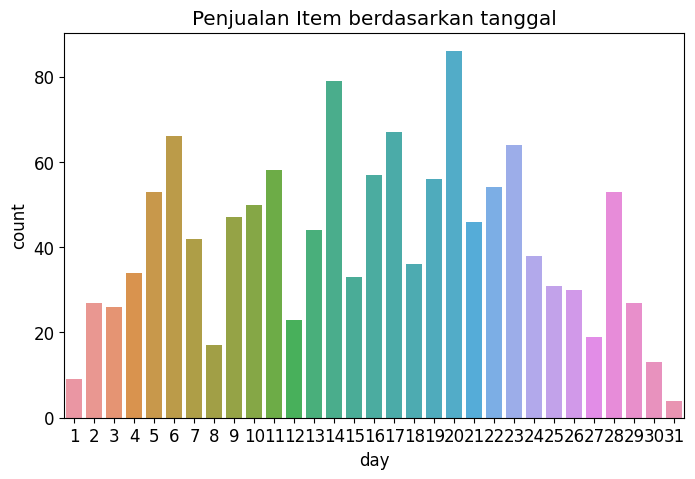

In [21]:
plt.figure(figsize=(8,5))
sns.countplot(x='day',data=df)
plt.title('Penjualan Item berdasarkan tanggal')
plt.show()

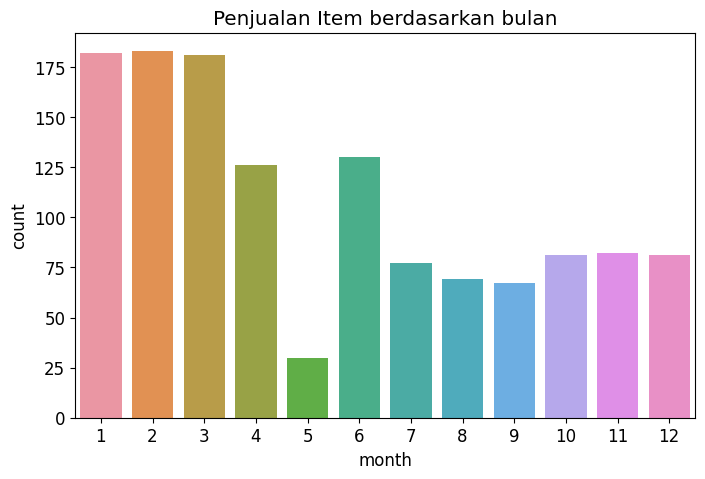

In [22]:
plt.figure(figsize=(8,5))
sns.countplot(x='month',data=df)
plt.title('Penjualan Item berdasarkan bulan')
plt.show()

In [23]:
df["nama.barang"] = df["nama.barang"].apply(lambda item: item.lower())

In [24]:
df["nama.barang"] = df["nama.barang"].apply(lambda item: item.strip())

In [25]:
df = df[["nama.pembeli", "nama.barang"]].copy()

In [26]:
df.head()

,nama.pembeli,nama.barang
0,TOKO HERUNIAWATI,beras
1,TOKO HERUNIAWATI,daging
2,TOKO APRILIA SUKRISNI,beras
3,TOKO APRILIA SUKRISNI,migor
4,TOKO APRILIA SUKRISNI,tepung


# modeling

In [27]:
item_count = df.groupby(["nama.pembeli", "nama.barang"])["nama.barang"].count().reset_index(name="Count")
item_count.head(10)

,nama.pembeli,nama.barang,Count
0,ANAPSA,beras,3
1,ANAPSA,daging,3
2,ANAPSA,gula,1
3,ANDY,beras,3
4,ANDY,daging,2
5,HOLIDAY MART,gula,2
6,Harya Sari,beras,3
7,Harya Sari,daging,2
8,KARUNIA,beras,4
9,KARUNIA,daging,4


In [28]:
item_count_pivot = item_count.pivot_table(index='nama.pembeli', columns='nama.barang', values='Count', aggfunc='sum').fillna(0)
print("ukuran dataset : ", item_count_pivot.shape)
item_count_pivot.head(5)

ukuran dataset :  (171, 5)


nama.barang,beras,daging,gula,migor,tepung
nama.pembeli,,,,,
ANAPSA,3.0,3.0,1.0,0.0,0.0
ANDY,3.0,2.0,0.0,0.0,0.0
HOLIDAY MART,0.0,0.0,2.0,0.0,0.0
Harya Sari,3.0,2.0,0.0,0.0,0.0
KARUNIA,4.0,4.0,0.0,0.0,0.0


In [29]:
item_count_pivot = item_count_pivot.astype("int32")
item_count_pivot.head()

nama.barang,beras,daging,gula,migor,tepung
nama.pembeli,,,,,
ANAPSA,3,3,1,0,0
ANDY,3,2,0,0,0
HOLIDAY MART,0,0,2,0,0
Harya Sari,3,2,0,0,0
KARUNIA,4,4,0,0,0


In [30]:
def encode(x):
    if x <=0:
        return 0
    elif x >= 1:
        return 1

item_count_pivot = item_count_pivot.applymap(encode)
item_count_pivot.head()

nama.barang,beras,daging,gula,migor,tepung
nama.pembeli,,,,,
ANAPSA,1,1,1,0,0
ANDY,1,1,0,0,0
HOLIDAY MART,0,0,1,0,0
Harya Sari,1,1,0,0,0
KARUNIA,1,1,0,0,0


In [31]:
print("ukuran dataset : ", item_count_pivot.shape)
print("jumlah transaksi : ", item_count_pivot.shape[0])
print("jumlah item : ", item_count_pivot.shape[1])

ukuran dataset :  (171, 5)
jumlah transaksi :  171
jumlah item :  5


In [32]:
support = 0.01
frequent_items = apriori(item_count_pivot, min_support=support, use_colnames=True)
frequent_items.sort_values("support", ascending=False).head(10)

,support,itemsets
0,0.912281,(beras)
1,0.397661,(daging)
5,0.374269,"(beras, daging)"
2,0.286550,(gula)
6,0.216374,"(beras, gula)"
9,0.210526,"(gula, daging)"
15,0.192982,"(beras, gula, daging)"
3,0.192982,(migor)
4,0.187135,(tepung)
7,0.175439,"(migor, beras)"


In [33]:
metric = "lift"
min_treshold = 1

rules = association_rules(frequent_items, metric=metric, min_threshold=min_treshold)[["antecedents","consequents","support","confidence","lift"]]
rules.sort_values('confidence', ascending=False,inplace=True)
rules.head(15)

,antecedents,consequents,support,confidence,lift
126,"(tepung, gula, daging)",(migor),0.093567,1.000000,5.181818
113,"(beras, gula, tepung)",(migor),0.105263,1.000000,5.181818
142,"(daging, tepung, gula, beras)",(migor),0.087719,1.000000,5.181818
41,"(beras, tepung)",(migor),0.152047,0.962963,4.989899
21,"(migor, daging)",(beras),0.134503,0.958333,1.050481
31,"(migor, gula)",(beras),0.122807,0.954545,1.046329
64,"(tepung, gula)",(migor),0.111111,0.950000,4.922727
98,"(daging, tepung, beras)",(migor),0.111111,0.950000,4.922727
97,"(migor, tepung, daging)",(beras),0.111111,0.950000,1.041346
112,"(migor, gula, tepung)",(beras),0.105263,0.947368,1.038462


# Visualisasi hasil algoritma

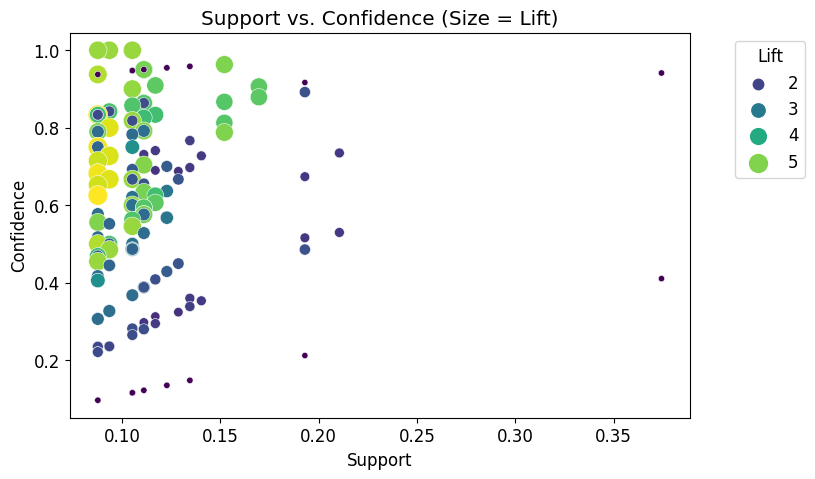

In [34]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x="support", y="confidence", size="lift", data=rules, hue="lift", palette="viridis", sizes=(20, 200))
plt.title('Support vs. Confidence (Size = Lift)')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.legend(title='Lift', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

In [35]:
G = nx.DiGraph()

# Add nodes and edges from association rules
for idx, row in rules.iterrows():
    G.add_node(tuple(row['antecedents']), color='skyblue')
    G.add_node(tuple(row['consequents']), color='orange')
    G.add_edge(tuple(row['antecedents']), tuple(row['consequents']), weight=row['support'])

# Set node positions using a spring layout
pos = nx.spring_layout(G)

# Create an interactive plot using plotly
edge_x = []
edge_y = []
for edge in G.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        )
    )
)

# Customize the layout
layout = go.Layout(
    showlegend=False,
    hovermode='closest',
    margin=dict(b=0, l=0, r=0, t=0),
)

# Create the figure
fig = go.Figure(data=[edge_trace, node_trace], layout=layout)

# Show the interactive graph
fig.show()

# save model (pickle)

In [ ]:
code 1

In [ ]:
code 2

In [ ]:
code 3